In [1]:
import requests
from datetime import datetime
import time
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
sr = pd.read_csv('https://github.com/jdfoote/Intro-to-Programming-and-Data-Science/blob/fall2021/resources/data/sr_post_data.csv?raw=true')

In [21]:
# Change the date to a datetime, and put it in the index
sr.index = pd.to_datetime(sr.date)

### EXERCISE 1

Modify the code above to plot how often "Coronavirus" is used in each of the three subreddits over time

In [22]:
sr.head()

,title,selftext,date,subreddit
date,,,,
2021-09-25 03:59:39,"FALSE: US records 12,366 deaths due to COVID-1...",NaN,2021-09-25 03:59:39,Coronavirus
2021-09-25 03:55:12,Researchers who developed the mRNA technology ...,NaN,2021-09-25 03:55:12,Coronavirus
2021-09-25 02:51:33,The United States Completes Donation of 3.5 mi...,NaN,2021-09-25 02:51:33,Coronavirus
2021-09-25 02:25:46,When will the pandemic end? Models project a d...,NaN,2021-09-25 02:25:46,Coronavirus
2021-09-25 01:55:31,Thousands of teachers may be forced out of NYC...,NaN,2021-09-25 01:55:31,Coronavirus


In [23]:
sr.subreddit.unique()

array(['Coronavirus', 'politics', 'aww'], dtype=object)

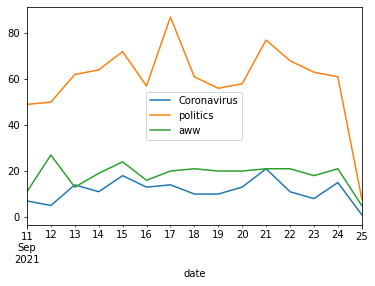

In [57]:
subreddits = ['Coronavirus', 'politics', 'aww']
term = 'is'
for subreddit in sr.subreddit.unique():
    curr_df = sr.loc[sr.subreddit == subreddit, ['title', 'selftext']]
    curr_df = curr_df.loc[curr_df.title.str.contains(term) | curr_df.selftext.str.contains(term), ]
    #print(curr_df)
    posts_per_day = curr_df.resample('D').size()
    #print(posts_per_day)
    try:
        posts_per_day.plot(label = subreddit)
    except ValueError:
        continue

plt.legend()
plt.show()

### EXERCISE 2

One of the trickiest parts of analysis is getting the data in the form that you want it in order to analyze/visualize it. 

I think a good visualization for this would be a barplot showing how often male and female word types appear for each subreddit. I'll give you the final call to produce the plot:

`sns.barplot(x='subreddit', y='proportion', hue = 'word_gender', data = agg_df_long)`

Now, see if you can get the data in shape so that this code actually works! :)

*Hint: You'll want to use [wide to long](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.wide_to_long.html)*

In [125]:
def get_words_ratio(strings):
    result = {}
    for name, group in sr.groupby('subreddit').all_text:
        result[name] = {'matches':0, 'all_words': 0}
        for s in group:
            text_list = s.split()
            for string in strings:
                result[name]['matches'] += text_list.count(string)
            result[name]['all_words'] += len(text_list)
    final_result = {}
    for name, values in result.items():
        final_result[name] = values['matches'] / values['all_words']
    return final_result
        

In [126]:
get_words_ratio(['he', 'his'])

{'Coronavirus': 0.0018737557090994263,
 'aww': 0.011129173440040016,
 'politics': 0.003949948899262492}

In [98]:
sr.loc[(pd.isna(sr.selftext)) | (sr.selftext.isin(['[removed]', '[deleted]'])), 'selftext'] = ''
sr['all_text'] = sr.title + ' ' + sr.selftext

male_words = ['he', 'his']
female_words = ['she', 'hers']

# This puts all of the text of each subreddit into lists
def string_to_list(x):
   # print(' '.join(x))
    return ' '.join(x).split()
grouped_text = sr.groupby('subreddit').all_text.apply(string_to_list)

# Then, we count how often each type of words appears in each subreddit
agg = grouped_text.aggregate({'proportionMale': lambda x: sum([x.count(y) for y in male_words])/len(x),
                        'proportionFemale': lambda x: sum([x.count(y) for y in female_words])/len(x)}
                        )

In [109]:
agg

                  subreddit  
proportionMale    Coronavirus    0.001874
                  aww            0.011129
                  politics       0.003950
proportionFemale  Coronavirus    0.000234
                  aww            0.003251
                  politics       0.000525
Name: all_text, dtype: float64

In [107]:
agg_df = agg.unstack(level=0)
agg_df = agg_df.reset_index()

agg_df_long = pd.wide_to_long(agg_df, # The data
                # The prefixes for the data columns. These will become column names that hold data values.
                stubnames = 'proportion', 
                # i is a column which uniquely identifies each row
                i='subreddit',
                # j is what you want to call the prefix
                j='word_gender',
                # sep is a string that is between the stubnames and the values which will go in j
                sep='',
                suffix = '\w+'
               )

agg_df_long = agg_df_long.reset_index()


<AxesSubplot:xlabel='subreddit', ylabel='proportion'>

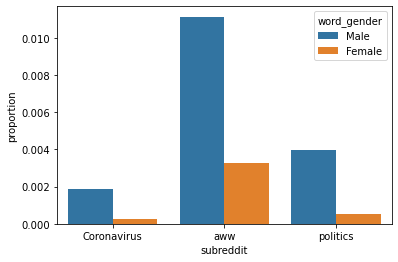

In [108]:
sns.barplot(x='subreddit', y='proportion', hue = 'word_gender', data = agg_df_long)

### EXERCISE 3

Make your own analysis, with a different set of terms

### EXERCISE 4

Where topic modeling really shines is in analyzing longer texts - for example, the subreddit [changemyview](https://www.reddit.com/r/changemyview/) has fairly long posts where people explain a controversial view that they hold.

Try to figure out how to get a few hundred posts from changemyview, and run a topic model on them, where the selftext of each post is a document.

In [49]:
## Code used to create the dataset - no need to run this code

endpt = 'https://api.pushshift.io/reddit/search/submission'

subreddits = ['changemyview']

# Start and end date (pushshift expects these in epoch time)
start_date = int(datetime.strptime('2020-03-11', '%Y-%m-%d').timestamp())
end_date = int(datetime.strptime('2020-03-25', '%Y-%m-%d').timestamp())


def get_posts(subreddit, before = end_date, after = start_date, result = None,  min_comments = 20):
    params = {'subreddit': subreddit,
              'num_comments': f'>{min_comments}',
              'before': before,
              'size': 500
             }
    if result == None:
        result = []
    r = requests.get(endpt, params=params)
    print(r.url)
    print(datetime.fromtimestamp(before))
    for item in r.json()['data']:
        created_time = item['created_utc']
        if created_time < after: # If we've reached the earliest we want, then return
            print(len(result))
            return result
        else:
            try:
                result.append((item['title'],item['selftext'], created_time, subreddit))
            except KeyError:
                print(item)
    time.sleep(.5)
    return get_posts(subreddit, before = created_time, result = result)


sr_data = []
for subreddit in subreddits:
    new_data = get_posts(subreddit)
    sr_data = sr_data + new_data
sr = pd.DataFrame(sr_data, columns = ['title', 'selftext', 'date', 'subreddit'])
sr.date = pd.to_datetime(sr.date, unit='s')
sr.to_csv('./change_my_view.csv', index = False)

https://api.pushshift.io/reddit/search/submission?subreddit=changemyview&num_comments=%3E20&before=1585108800&size=500
2020-03-25 00:00:00
https://api.pushshift.io/reddit/search/submission?subreddit=changemyview&num_comments=%3E20&before=1584813062&size=500
2020-03-21 13:51:02
https://api.pushshift.io/reddit/search/submission?subreddit=changemyview&num_comments=%3E20&before=1584507012&size=500
2020-03-18 00:50:12
https://api.pushshift.io/reddit/search/submission?subreddit=changemyview&num_comments=%3E20&before=1584262715&size=500
2020-03-15 04:58:35
https://api.pushshift.io/reddit/search/submission?subreddit=changemyview&num_comments=%3E20&before=1583974710&size=500
2020-03-11 20:58:30
457


In [53]:
dataset = sr.selftext
run_lda(dataset)

Loading dataset...
done in 0.000s.
Extracting tf features for LDA...
done in 0.412s.
Fitting LDA models with tf features, n_samples=457 and n_features=20000...
done in 6.003s.
Topics by how common each topic is:
          1          3                      5                  7  \
0    people       time                removed           officers   
1      like  marijuana                   like        enforcement   
2       don     people                  karma  "police officers"   
3      just       just                 people  "law enforcement"   
4     think        amp                    don             people   
5      want     states                   just             police   
6      time       jews                   subs               acab   
7      make       does        "posts removed"              think   
8       way      exist  "removed immediately"           bastards   
9   believe      think          "account age"               like   
10     life      water     "original con